Code borrowed from https://github.com/csaguiar/arrhythmia-detection/blob/master/MIT-BIH-arrhythmia-dl.ipynb

Data sourced from https://www.physionet.org/content/mitdb/1.0.0/

Stanford paper https://stanfordmlgroup.github.io/projects/ecg/


In [36]:
!pwd

/content/ArrhythmiaDetection


In [37]:
%cd  ArrhythmiaDetection/

[Errno 2] No such file or directory: 'ArrhythmiaDetection/'
/ArrhythmiaDetection


In [72]:
!git checkout -b julia_patient_time_series
!git status
!pwd

!git add 'SimpleTimeSeriesAndNLP.ipynb'

Switched to a new branch 'julia_patient_time_series'
On branch julia_patient_time_series

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	mit-bih-arrhythmia-database-1.0.0.zip
	mit-bih-arrhythmia-database-1.0.0/

nothing added to commit but untracked files present (use "git add" to track)
/content/ArrhythmiaDetection
fatal: pathspec 'SimpleTimeSeriesAndNLP.ipynb' did not match any files


In [39]:
!ls


# Setup - install additional libraries

In [40]:
!pip install wfdb
!pip install wget

# Background to wfdb : https://wfdb.readthedocs.io/en/latest/

     |████████████████████████████████| 137 kB 5.3 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=e40c5c6a9110e57da4034a1d285b15195b0bb8704459c14b177988c60869daa0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Load the data

In [41]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path

In [42]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    # this url returns a HTTP 400 error, 
    #url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'

    # so replaced with this, which works by the look of it, and loads data into the colabs environment
    url = f'https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

In [43]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [44]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

In [45]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0

In [46]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [47]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    comment = record.comments
    unit = record.units
    p_signal = record.p_signal
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "comment": comment,
        "unit": unit,
        "p_signal": p_signal,
        "fs": fs,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [48]:
len(all_sequences)

109132

# Plotting

Let's try to examine an individual patient record/waveform

Then plot each patient:

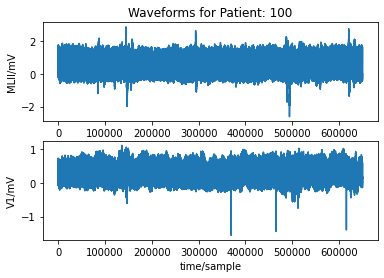

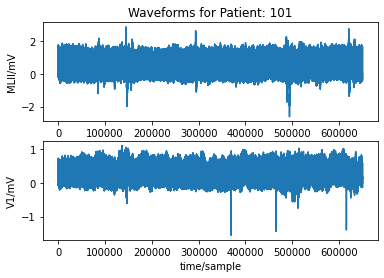

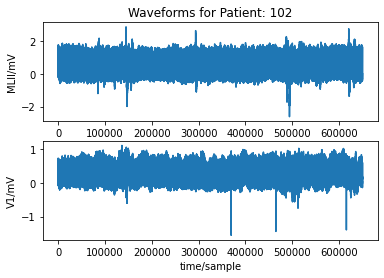

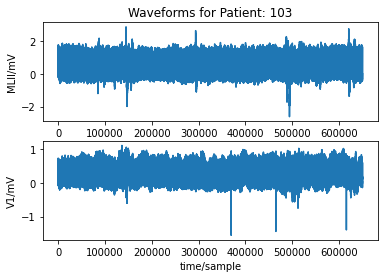

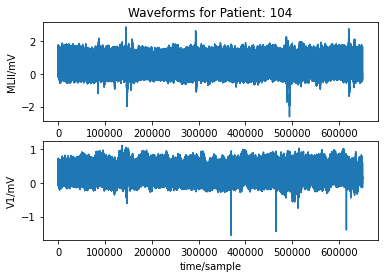

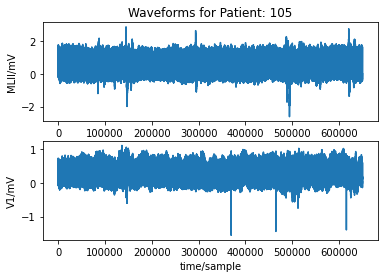

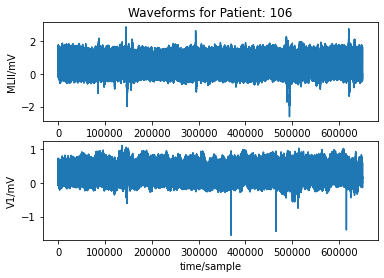

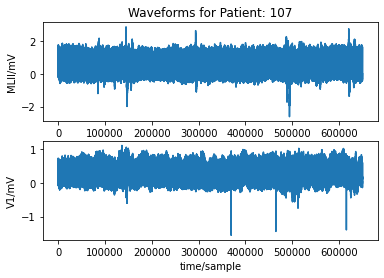

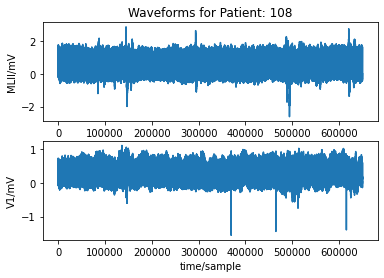

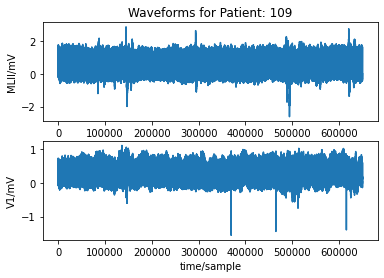

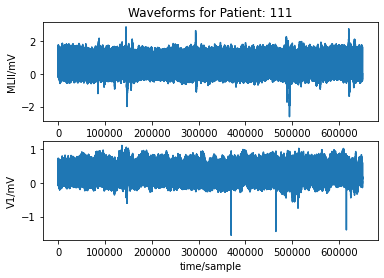

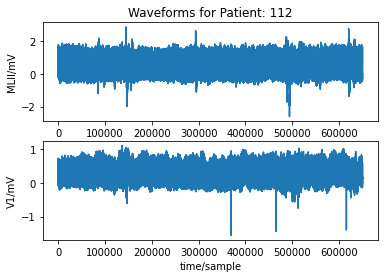

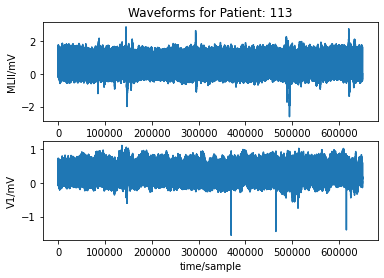

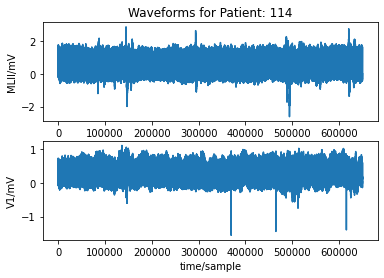

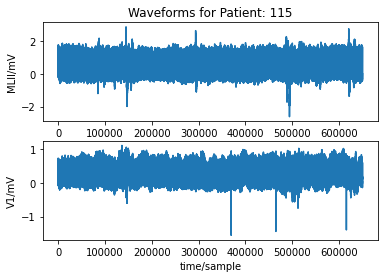

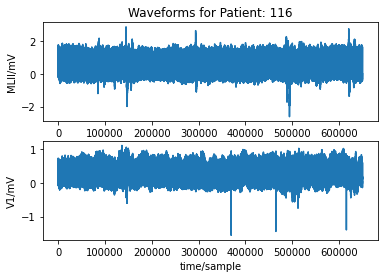

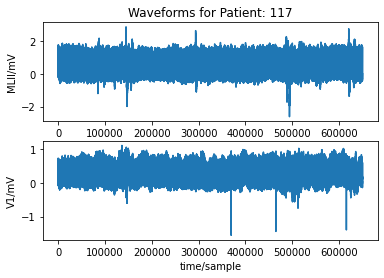

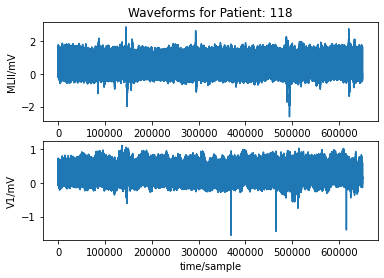

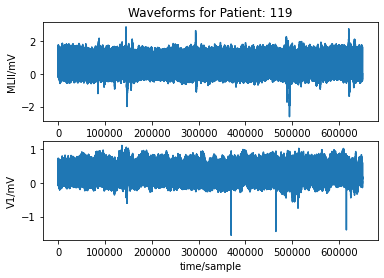

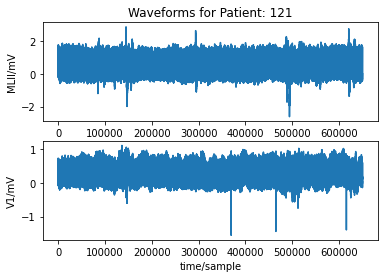

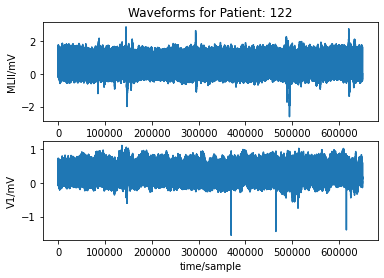

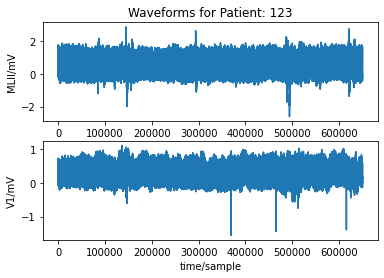

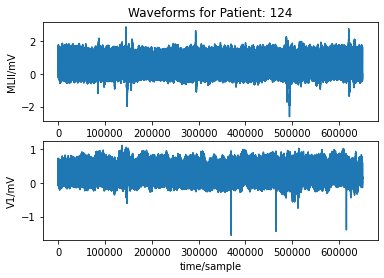

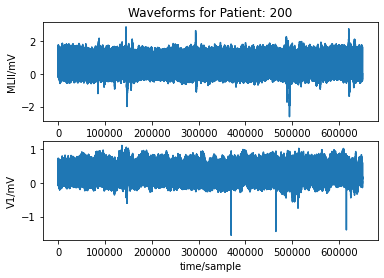

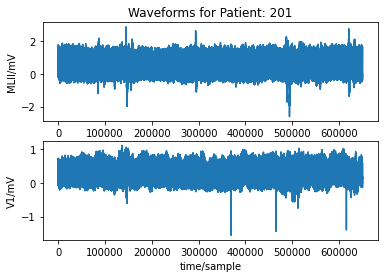

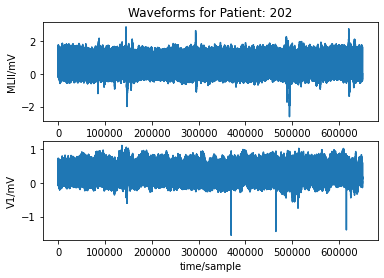

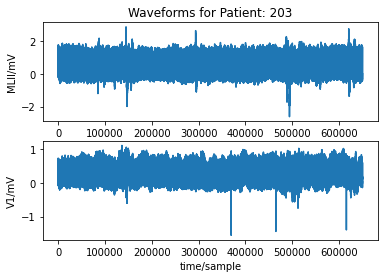

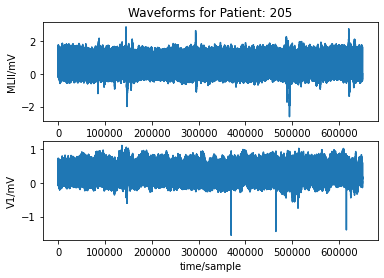

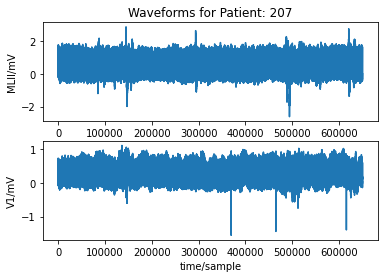

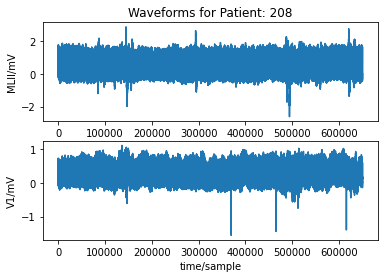

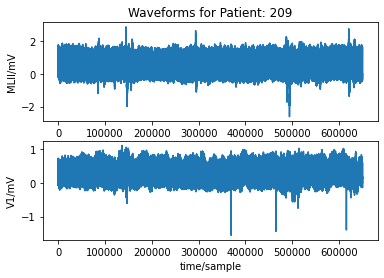

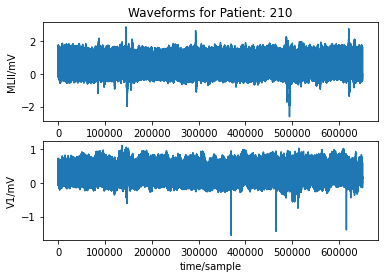

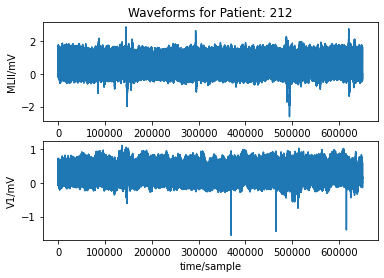

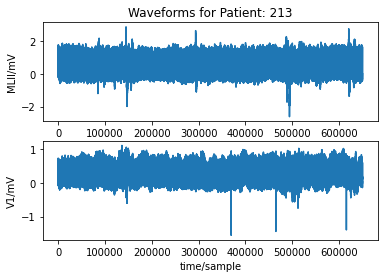

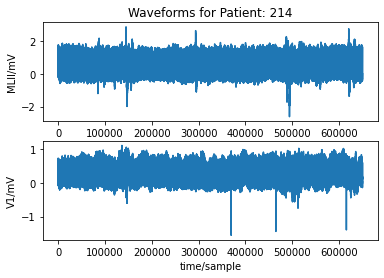

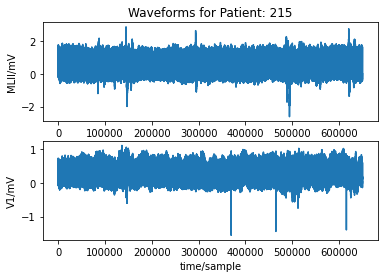

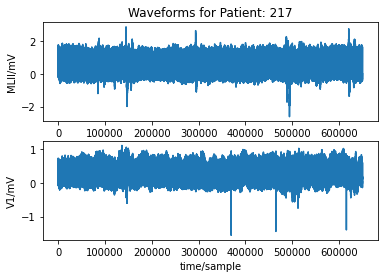

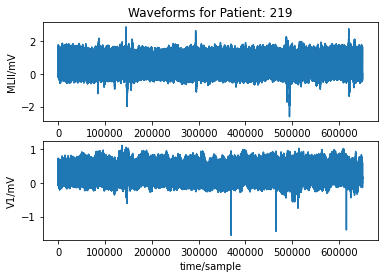

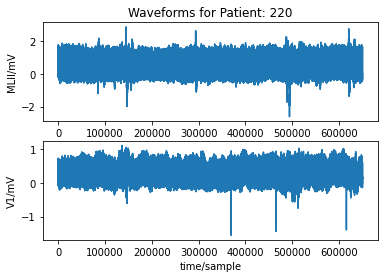

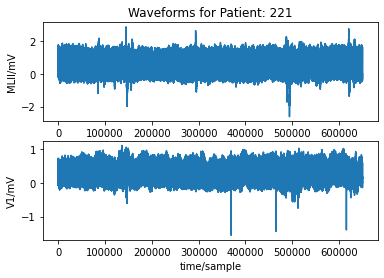

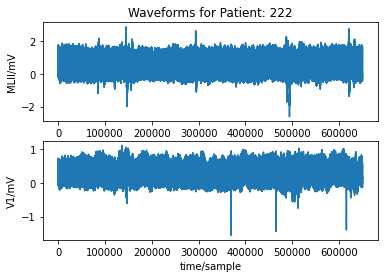

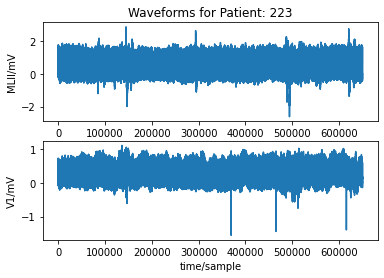

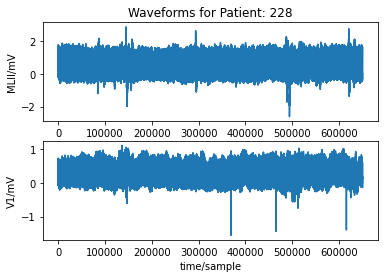

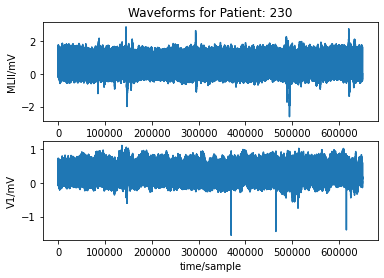

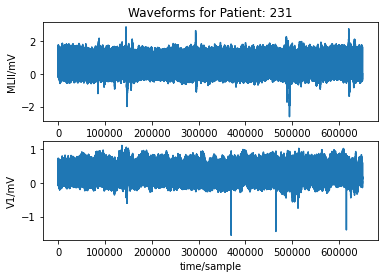

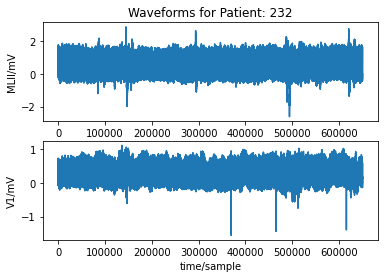

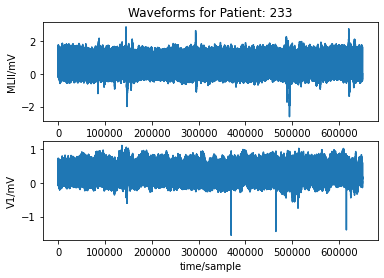

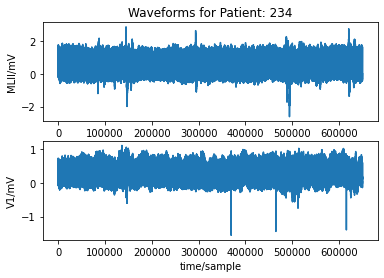

In [49]:
for subject in records:
  wfdb.plot_wfdb(record=record, title=f'Waveforms for Patient: {subject}') 

  

In [50]:
display(record.__dict__)

{'adc_gain': [200.0, 200.0],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [1024, 1024],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [18427, 21057],
 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['234.dat', '234.dat'],
 'fmt': ['212', '212'],
 'fs': 360,
 'init_value': [1008, 1051],
 'n_sig': 2,
 'p_signal': array([[-0.08 ,  0.135],
        [-0.08 ,  0.135],
        [-0.08 ,  0.135],
        ...,
        [-0.395,  0.075],
        [-0.38 ,  0.08 ],
        [ 0.   ,  0.   ]]),
 'record_name': '234',
 'samps_per_frame': [1, 1],
 'sig_len': 650000,
 'sig_name': ['MLII', 'V1'],
 'skew': [None, None],
 'units': ['mV', 'mV']}

In [51]:
subject_map = pd.DataFrame(subject_map)

In [52]:
subject_map.head()

,subject,comment,unit,p_signal,fs,percentage,num_seq,start,end
0,100,"[69 M 1085 1629 x1, Aldomet, Inderal]","[mV, mV]","[[-0.145, -0.065], [-0.145, -0.065], [-0.145, ...",360,0.015018,2264,0,2264
1,101,"[75 F 1011 654 x1, Diapres]","[mV, mV]","[[-0.345, -0.16], [-0.345, -0.16], [-0.345, -0...",360,0.002691,1858,2264,4122
2,102,"[84 F 1525 167 x1, Digoxin, The rhythm is pace...","[mV, mV]","[[-0.2, 0.005], [-0.2, 0.005], [-0.2, 0.005], ...",360,0.954566,2179,4122,6301
3,103,"[-1 M 742 654 x1, Diapres, Xyloprim]","[mV, mV]","[[-0.375, 0.05], [-0.375, 0.05], [-0.375, 0.05...",360,0.000962,2078,6301,8379
4,104,"[66 F 1567 694 x1, Digoxin, Pronestyl, The rat...","[mV, mV]","[[-0.15, 0.2], [-0.15, 0.2], [-0.15, 0.2], [-0...",360,0.926610,2221,8379,10600


In [53]:
print(subject_map.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject     48 non-null     int64  
 1   comment     48 non-null     object 
 2   unit        48 non-null     object 
 3   p_signal    48 non-null     object 
 4   fs          48 non-null     int64  
 5   percentage  48 non-null     float64
 6   num_seq     48 non-null     int64  
 7   start       48 non-null     int64  
 8   end         48 non-null     int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.5+ KB
None


# Text Analysis

Looks like there are drugs details in the comments - we could do a bit of basic NLP...for no other reason than to enhance our time series model features. 

Still can't seem to grasp the time aspect - can we go with (waveform = 70 beats per minute?)

In [55]:
import string
import collections
import nltk
import seaborn as sns

In [56]:
for c in subject_map['comment']:
  print(c)

#Looks like age, gender, ? then drugs/patient history?

['69 M 1085 1629 x1', 'Aldomet, Inderal']
['75 F 1011 654 x1', 'Diapres']
['84 F 1525 167 x1', 'Digoxin', 'The rhythm is paced with a demand pacemaker.  The PVCs are multiform.']
['-1 M 742 654 x1', 'Diapres, Xyloprim']
['66 F 1567 694 x1', 'Digoxin, Pronestyl', 'The rate of paced rhythm is close to that of the underlying sinus rhythm,', 'resulting in many pacemaker fusion beats.  The PVCs are multiform.  Several', 'bursts of muscle noise occur, but the signals are generally of good quality.']
['73 F 1624 1629 x1', 'Digoxin, Nitropaste, Pronestyl', 'The PVCs are uniform.  The predominant feature of this tape is', 'high-grade noise and artifact.']
['24 F 1581 654 x1', 'Inderal', 'The PVCs are multiform.']
['63 M 1340 167 x1', 'Digoxin', 'Complete heart block is present. The PVCs are multiform.']
['87 F 1227 654 x1', 'Digoxin, Quinaglute', 'There is borderline first degree AV block and sinus arrhythmia.  The', 'PVCs are multiform.  The lower channel exhibits considerable noise and', 'bas

In [57]:
subject_map.head()

,subject,comment,unit,p_signal,fs,percentage,num_seq,start,end
0,100,"[69 M 1085 1629 x1, Aldomet, Inderal]","[mV, mV]","[[-0.145, -0.065], [-0.145, -0.065], [-0.145, ...",360,0.015018,2264,0,2264
1,101,"[75 F 1011 654 x1, Diapres]","[mV, mV]","[[-0.345, -0.16], [-0.345, -0.16], [-0.345, -0...",360,0.002691,1858,2264,4122
2,102,"[84 F 1525 167 x1, Digoxin, The rhythm is pace...","[mV, mV]","[[-0.2, 0.005], [-0.2, 0.005], [-0.2, 0.005], ...",360,0.954566,2179,4122,6301
3,103,"[-1 M 742 654 x1, Diapres, Xyloprim]","[mV, mV]","[[-0.375, 0.05], [-0.375, 0.05], [-0.375, 0.05...",360,0.000962,2078,6301,8379
4,104,"[66 F 1567 694 x1, Digoxin, Pronestyl, The rat...","[mV, mV]","[[-0.15, 0.2], [-0.15, 0.2], [-0.15, 0.2], [-0...",360,0.926610,2221,8379,10600


In [58]:
patient_102 = subject_map[subject_map['subject'] == 102]

In [60]:
subject_map.describe()

,subject,fs,percentage,num_seq,start,end
count,48.000000,48.0,48.000000,48.000000,48.000000,48.000000
mean,166.229167,360.0,0.324887,2273.583333,51641.520833,53915.104167
std,53.622494,0.0,0.395465,450.785784,31914.617065,32044.416846
min,100.000000,360.0,0.000000,1512.000000,0.000000,2264.000000
25%,112.750000,360.0,0.017210,1954.250000,25611.250000,27585.000000
50%,200.500000,360.0,0.157546,2211.500000,48781.500000,51056.500000
75%,215.500000,360.0,0.698289,2571.250000,79289.250000,82354.500000
max,234.000000,360.0,1.000000,3353.000000,106387.000000,109132.000000


num_seq is the difference between start and end as the values generated below match those of num_seq

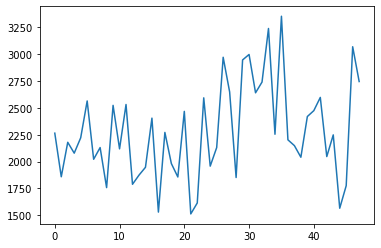

In [61]:
plt.plot(subject_map['num_seq'])

In [62]:
df_lagged = subject_map.copy()

In [63]:
df_lagged['lag'] = subject_map['end'] - subject_map['start']

In [64]:
df_lagged.head()

,subject,comment,unit,p_signal,fs,percentage,num_seq,start,end,lag
0,100,"[69 M 1085 1629 x1, Aldomet, Inderal]","[mV, mV]","[[-0.145, -0.065], [-0.145, -0.065], [-0.145, ...",360,0.015018,2264,0,2264,2264
1,101,"[75 F 1011 654 x1, Diapres]","[mV, mV]","[[-0.345, -0.16], [-0.345, -0.16], [-0.345, -0...",360,0.002691,1858,2264,4122,1858
2,102,"[84 F 1525 167 x1, Digoxin, The rhythm is pace...","[mV, mV]","[[-0.2, 0.005], [-0.2, 0.005], [-0.2, 0.005], ...",360,0.954566,2179,4122,6301,2179
3,103,"[-1 M 742 654 x1, Diapres, Xyloprim]","[mV, mV]","[[-0.375, 0.05], [-0.375, 0.05], [-0.375, 0.05...",360,0.000962,2078,6301,8379,2078
4,104,"[66 F 1567 694 x1, Digoxin, Pronestyl, The rat...","[mV, mV]","[[-0.15, 0.2], [-0.15, 0.2], [-0.15, 0.2], [-0...",360,0.926610,2221,8379,10600,2221


In [65]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [66]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [67]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [68]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [69]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

# Train the CNN

In [70]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
flatten (Flatten)            (None, 17280)             0         
_________________________________________________________________
dropout (Dropout)            (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [71]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
648/648 [==============================] - 72s 86ms/step - loss: 0.3002 - accuracy: 0.8828 - val_loss: 0.5665 - val_accuracy: 0.8208
Epoch 2/15
648/648 [==============================] - 55s 85ms/step - loss: 0.1839 - accuracy: 0.9383 - val_loss: 0.5961 - val_accuracy: 0.8341
Epoch 3/15
648/648 [==============================] - 55s 85ms/step - loss: 0.1673 - accuracy: 0.9445 - val_loss: 0.5827 - val_accuracy: 0.8183
Epoch 4/15
510/648 [======================>.......] - ETA: 10s - loss: 0.1565 - accuracy: 0.9480

KeyboardInterrupt: ignored

In [ ]:
cnn_model.evaluate(X_val, y_val)

In [ ]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN with LSTM

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [ ]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

In [ ]:
train_params = {
    "batch_size": 128,
    "epochs": 15,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

In [ ]:
cnn_lstm_model.evaluate(X_val, y_val)

In [ ]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()